# Implementation of an Autoencoder (VAE)
#### based on the VE implementation and https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a
## Simple linear VAE with one layer into hidden (latent) space 748 -> 256 -> 12 and back 12 -> 256 -> 748

#### Build for MINST datasets

In [1]:
#import os
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor

In [2]:
batch_size = 256

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"   ### needed if Nvidia GPU is available and wanted to use the GPU
print(f"Using {device} device")

Using cuda device


In [4]:
### Building the neural network structure ####

dim_encoder_decoder=784
dim_hidden=256
dim_latent=16

class VAE(nn.Module):
    def __init__(self, dim_encoder_decoder=784, dim_hidden=256, dim_latent=16):
        super(VAE , self).__init__()
        
        self.decoder = nn.Sequential(                             # sequential operation of the following code:
            nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer (16 -> 256 nodes)
            nn.ReLU(),                                            # activation function f(x) = max(0, x)
            nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image (256 -> 784)
            nn.Sigmoid() #nn.Softmax()                            # rescale values between ]0,1[ by the sigmoidal function
        )
        
        self.encoder_layer = nn.Sequential(                       # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer (784 -> 256 nodes)
            nn.ReLU(),                                            # activation function
        )
        
        self.hidden_to_mu = nn.Linear(dim_hidden, dim_latent)     # hidden layer in dim_latent for mu
        self.hidden_to_sigma = nn.Linear(dim_hidden, dim_latent)  # hidden layer in dim_latent for sigma


    def encoder(self, x):
        hidden_layer = self.encoder_layer(x)
        mu = self.hidden_to_mu(hidden_layer)                      # get the mean
        sigma = self.hidden_to_sigma(hidden_layer)                # get the standard devation
        return mu , sigma                                         # return the encoded 

        
    def forward(self, x):                                         # 
        mu, sigma = self.encoder(x)                               # compute the variance and mean of a reduced dim
        epsilon = torch.randn_like(sigma)                         # random noice ### "Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1"
        z = mu + sigma*epsilon                                    # reparametrization # compute latent layer from reduced dim of mu and sigma and some random noice
        decoded = self.decoder(z)                                 # decode latent layer
        return decoded , mu, sigma , z                            # return the decoded vector, mean, standard devation, latent vector


model = VAE().to(device) #### this is needed for cuda
print(model)


VAE(
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (encoder_layer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (hidden_to_mu): Linear(in_features=256, out_features=16, bias=True)
  (hidden_to_sigma): Linear(in_features=256, out_features=16, bias=True)
)


In [5]:
loss_fn = nn.MSELoss()                                        ### nn.MSELoss() (Mean Square Error) for regression tasks
loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4, )#

235it [00:06, 34.86it/s, loss_total=1.55e+7]
235it [00:05, 39.81it/s, loss_total=1.09e+7]
235it [00:06, 36.65it/s, loss_total=9.8e+6] 
235it [00:05, 40.69it/s, loss_total=9.23e+6]
235it [00:05, 41.11it/s, loss_total=8.89e+6]
235it [00:05, 41.89it/s, loss_total=8.64e+6]
235it [00:05, 41.89it/s, loss_total=8.43e+6]
235it [00:05, 41.71it/s, loss_total=8.29e+6]
235it [00:05, 42.74it/s, loss_total=8.19e+6]
235it [00:05, 42.62it/s, loss_total=8.11e+6]
235it [00:05, 42.19it/s, loss_total=8.04e+6]
235it [00:05, 43.19it/s, loss_total=7.98e+6]
235it [00:05, 42.81it/s, loss_total=7.93e+6]
235it [00:05, 42.47it/s, loss_total=7.89e+6]
235it [00:05, 41.44it/s, loss_total=7.85e+6]
235it [00:06, 36.79it/s, loss_total=7.82e+6]
235it [00:05, 43.24it/s, loss_total=7.8e+6] 
235it [00:05, 43.29it/s, loss_total=7.77e+6]
235it [00:05, 43.08it/s, loss_total=7.75e+6]
235it [00:05, 43.51it/s, loss_total=7.73e+6]
235it [00:05, 43.64it/s, loss_total=7.71e+6]
235it [00:05, 43.55it/s, loss_total=7.69e+6]
235it [00:

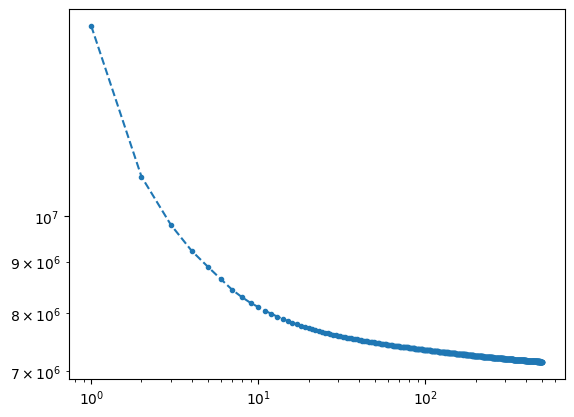

In [6]:
from tqdm import tqdm
n_epochs = 500

list_loss = []
torch.manual_seed(42)
for epoch in range(n_epochs):
    loop = tqdm(enumerate(train_dataloader))
    loss_total = 0
    for batch , (X, label) in loop:
        X = X.reshape(-1, dim_encoder_decoder).to(device)
        pred , mu, sigma , _ = model(X)
        re_loss = loss_fn(pred, X)
        kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = re_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        loop.set_postfix(loss_total=loss_total)
    list_loss.append(loss_total)
plt.plot([i+1 for i,x in enumerate(list_loss)], list_loss,"--.")
plt.yscale("log")
plt.xscale("log")
plt.show()

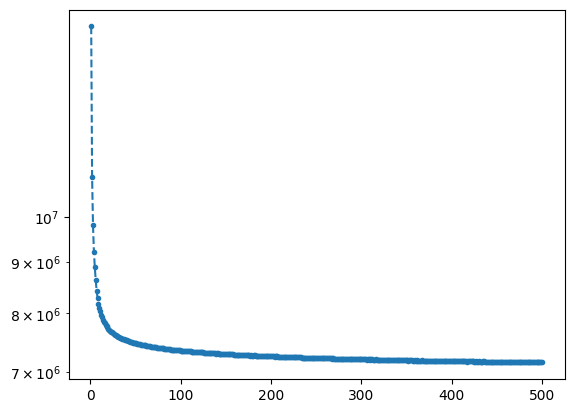

In [7]:
plt.plot([i+1 for i,x in enumerate(list_loss)], list_loss,"--.")
plt.yscale("log")
#plt.xscale("log")
plt.show()

In [8]:
#torch.save(model, 'VAE_MSE_100epoch_lr1e-4.pth')

import pandas as pd
encoded_samples = []
for sample in tqdm(mnist_data):
    img = sample[0].unsqueeze(0).reshape(-1, 28*28).to(device)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        decoded_img , mu, sigma , z  = model(img)
    # Append to list
    encoded_img = z.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.3)

In [9]:
loss_MSE = nn.MSELoss()  
loss_CrossEntropy = nn.CrossEntropyLoss()
loss_BCE = nn.BCELoss(reduction="sum")

loss_MSE_SUM = 0
loss_CrossEntropy_SUM = 0
loss_BCE_SUM = 0

for sample, label in tqdm(mnist_test):
    img = sample[0].unsqueeze(0).reshape(-1, 28*28).to(device)
    # Encode image
    model.eval()
    with torch.no_grad():
        decoded_img , mu, sigma , z  = model(img)
    
    loss_MSE_SUM += loss_MSE(decoded_img, img)
    loss_CrossEntropy_SUM += loss_CrossEntropy(decoded_img, img)
    loss_BCE_SUM += loss_BCE(decoded_img, img)
    
print("loss_MSE_SUM: ",loss_MSE_SUM.item(), " ; \n loss_CrossEntropy_SUM: ", 
     loss_CrossEntropy_SUM.item(), " ; \n loss_BCE_SUM: ", loss_BCE_SUM.item())

100%|██████████| 10000/10000 [00:06<00:00, 1525.32it/s]

loss_MSE_SUM:  163.7899627685547  ; 
 loss_CrossEntropy_SUM:  6363926.0  ; 
 loss_BCE_SUM:  872326.4375
